# $R(t)$ estimation
Daniele Proverbio - LCSB - 2020-09-15.  

During an epidemic evolution, estimating the time-dependent effective reproduction number [$R(t)$](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory) allows inspecting its control parameter as quantitative probe, and is also useful for cross-country comparison.  
The present algorithm is based on [Kevin Systrom's](https://github.com/k-sys/covid-19) - April 17. It is a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R(t)$ using a Bayesian approach. It is consistent with the one from Mathematical Modelling of Infectious Disases, London School of Hygiene and Tropical Medicine ([link](https://epiforecasts.io/covid/contributors.html)). Here, we adapted it for the countries considered for the analysis of EWS. Given the latest literature ([1](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article), [2](https://www.mdpi.com/2077-0383/9/4/967)), we set the [serial interval](https://en.wikipedia.org/wiki/Serial_interval) for [COVID-19](https://en.wikipedia.org/wiki/Coronavirus_disease_2019) as [about 4 days](https://www.jwatch.org/na51171/2020/03/27/serial-interval-covid-19).  
Note that incidence data are required.

#### Requirements:
numpy: 1.19.4  
pandas: 1.1.4         
matplotlib: 2.2.2  
scipy: 1.6.0     

In [20]:
# preliminary setting

import pandas as pd
import numpy as np
import datetime as DT

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

import os
from pathlib import Path

FILTERED_REGION_CODES = ['LUX']

%config InlineBackend.figure_format = 'retina'

#-----

state_name = 'LUX'
#index for date of rebound (the list was estimated a posteriori, and is used here for visualization purposes only)
#[VEN,SGP,NPL,LUX,KOR,JPN,ISR,DNK,AUT,AUS]=[156,184,189-120,159,204,158,128,193,161,157] 
index = 159 - 60     # (or -120 for NPL) is the "burn-in" period (see also idx_start below)
today = DT.datetime.now().strftime("%Y%m%d")

# prepare data, to get daily cases and smoothing
def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,    #7 days moving window for smoothing
        #win_type='gaussian',   #or comment whole line to have uniform
        min_periods=1,
        center=False).mean().round()
    
    idx_start = 60  #120 for Nepal, to avoid some mismatches during the first wave
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]

    return original, smoothed


#----

R_T_MAX = 10
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# getting highest density intervals
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


#-----

# getting posteriors for R_t evaluation
def get_posteriors(sr, date, sigma=0.15):

    # (1) Calculate Lambda
    gamma=1/np.random.normal(4, 0.2, len(r_t_range))
    lam = sr[:-1] * np.exp(gamma[:, None] * (r_t_range[:, None] - 1))
    #lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:], lam),
        index = r_t_range,
        columns = date[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=date,
        data={date[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(date[:-1], date[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood


## Load data

In [21]:
#load data
cwd = os.getcwd()
parent = Path(cwd).parent

path = f'{parent}/data/data_'f'{state_name}.txt'
states = pd.read_csv(path,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

In [22]:
# Prepare data for analysis

cases = states.xs(state_name).rename(f"{state_name} cases")
original, smoothed = prepare_cases(cases)

#convert into array for easier handling
original_array = original.values
smoothed_array = smoothed.values

# dates: what we have in real time are detected of cases, but they refer to infection happened several days ago
# comparing with Nowcasting procedures, this latency is 8±1 days
dates = smoothed.index
dates_detection = date2num(smoothed.index.tolist())
dates_infection = smoothed.index - DT.timedelta(days=9)
dates_infection = date2num(dates_infection.tolist())


## Estimate R_eff

In [23]:
#estimate R_t (for detection) and print 

R_T_MAX = 10
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

posteriors, log_likelihood = get_posteriors(smoothed_array, dates, sigma=0.06)    #optimal sigma already chosen in original Notebook

# Note that this is not the most efficient algorithm, but works fine
hdis = highest_density_interval(posteriors, p=.5)          # confidence bounds, p=50%

most_likely = posteriors.idxmax().rename('R_t-estimate')   #mean R_t value

result = pd.concat([most_likely, hdis], axis=1)            #global result for R_t-estimate
print(result.tail())

result.to_csv(f'{parent}/csv/'f'{state_name}_rt-estimate.csv')


            R_t-estimate  Low_50  High_50
date                                     
2020-08-12          0.83    0.65     0.89
2020-08-13          0.80    0.68     0.92
2020-08-14          0.84    0.71     0.95
2020-08-15          0.83    0.66     0.91
2020-08-16          0.83    0.66     0.91


In [24]:
current_prob1 = np.round(posteriors.iloc[100:,:].cumsum().iloc[-1] , 2)
current_prob1.to_csv(f'{parent}/csv/'f'{state_name}_expoProb.csv')

# Plots

In [25]:
#Plot R_t alone
#Plot only R_t (current)

def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    index = result['R_t-estimate'].index.get_level_values('date')
    values = result['R_t-estimate'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,values, s=10, lw=.5, edgecolors='k', zorder=2)
    
    lowfn = interp1d(date2num(index), result['Low_50'].values, bounds_error=False, fill_value='extrapolate')    
    highfn = interp1d(date2num(index), result['High_50'].values, bounds_error=False, fill_value='extrapolate')   
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'), end=index[-1])
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(result.index.get_level_values('date')[2], result.index.get_level_values('date')[-1])
    fig.set_facecolor('w')

/Users/daniele.proverbio/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/daniele.proverbio/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


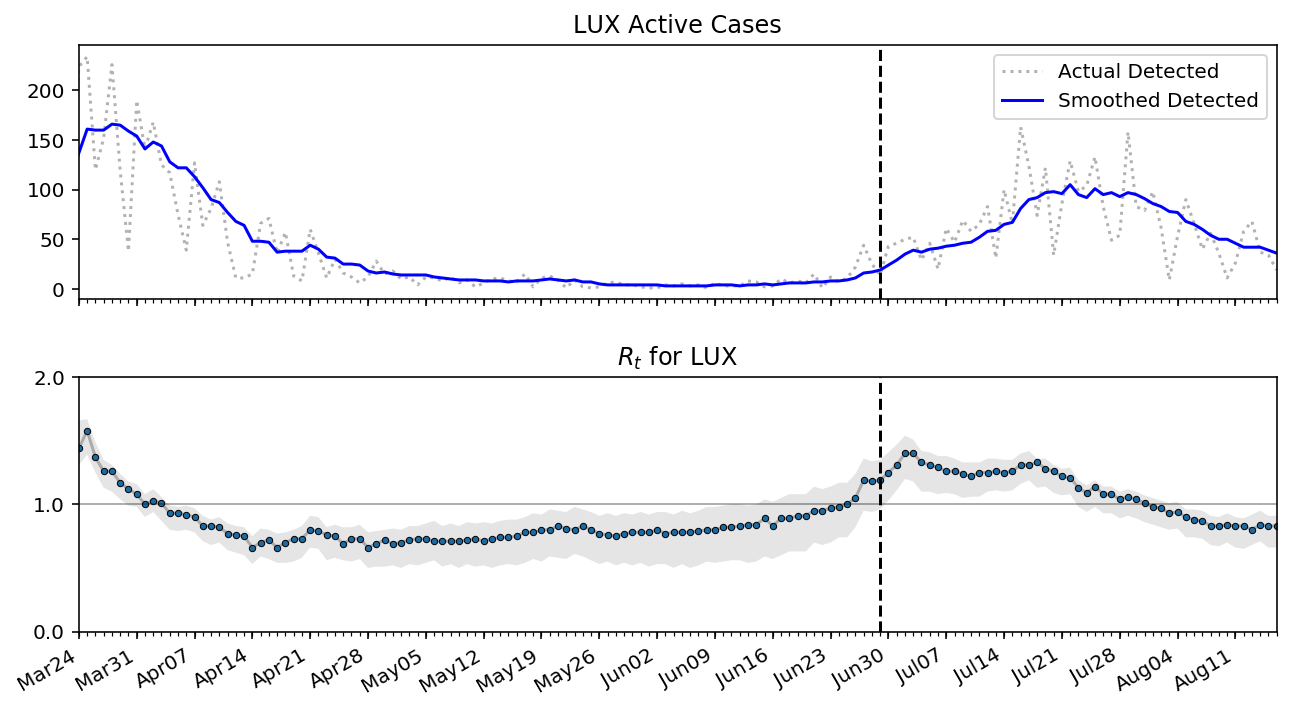

In [26]:

fig, ax = plt.subplots(2,figsize=(650/72,400/72))

#Fig 1
ax[0].set_title(f"{state_name} Active Cases")
ax[0].plot_date(dates_detection, original_array,':',alpha=.6,color="grey",label="Actual Detected")
ax[0].plot_date(dates_detection, smoothed_array,'b',label="Smoothed Detected")
ax[0].legend()

ax[0].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b%d'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
ax[0].set_xlim(dates_detection[2], dates_detection[-1])
ax[0].axvline(x=dates_detection[index],linestyle ='--',color='black')


#Fig 2
plot_rt(result, ax[1], state_name)
ax[1].set_title(f'$R_t$ for {state_name}')
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b%d'))
ax[1].axvline(x=dates_detection[index],linestyle ='--',color='black')
plt.tight_layout()

fig.autofmt_xdate()
fig.savefig(f'{parent}/R_t_plots/simulation_'+state_name+'_Reff.pdf',bbox_inches = "tight",transparent=True)
